In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:

def create_model(use_layer_norm=False):
    """Creates a small neural network with or without layer normalization."""
    layers = [nn.Linear(1, 10), nn.ReLU(), nn.Linear(10, 10), nn.ReLU()]
    if use_layer_norm:
        layers.append(nn.LayerNorm(10))
    layers.append(nn.Linear(10, 1))
    model = nn.Sequential(*layers)
    return model

def print_epoch_info(epoch, loss, model_name):
    """Prints the epoch information."""
    print(f"Model: {model_name} | Epoch {epoch + 1}: Loss = {loss:.4f}")

def train_and_collect_activations(model, x_train, y_train, *, epochs=100, model_name="N/A"):
    """Trains the model and collects activations from the second hidden layer."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    activations = []

    def hook(module, input, output):
        activations.append(output.detach().numpy())

    hook_handle = model[2].register_forward_hook(hook) #layer 2 is the second linear layer.

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # Tensor.item() is used to get the value of a **single-element tensor** as a Python number.
        print_epoch_info(epoch, loss.item(), model_name)

    hook_handle.remove()
    return activations

def visualize_covariance_shift(activations_no_norm, activations_norm):
    """Visualizes the covariance shift by plotting the distribution of activations."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Activations without Layer Normalization")
    for i in range(activations_no_norm[0].shape[1]):
        plt.hist([a[:, i] for a in activations_no_norm], bins=20, alpha=0.5, label=f"Neuron {i}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.title("Activations with Layer Normalization")
    for i in range(activations_norm[0].shape[1]):
        plt.hist([a[:, i] for a in activations_norm], bins=20, alpha=0.5, label=f"Neuron {i}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')

    plt.show()

def calculate_mean_and_variance(activations):
    means = []
    variances = []
    for layer_activations in activations:
        layer_mean = np.mean(layer_activations, axis=0)
        layer_variance = np.var(layer_activations, axis=0)
        means.append(layer_mean)
        variances.append(layer_variance)
    return means, variances

Model: Without Layer Norm | Epoch 1: Loss = 0.2126
Model: Without Layer Norm | Epoch 2: Loss = 0.2104
Model: Without Layer Norm | Epoch 3: Loss = 0.2080
Model: Without Layer Norm | Epoch 4: Loss = 0.2057
Model: Without Layer Norm | Epoch 5: Loss = 0.2034
Model: Without Layer Norm | Epoch 6: Loss = 0.2010
Model: Without Layer Norm | Epoch 7: Loss = 0.1987
Model: Without Layer Norm | Epoch 8: Loss = 0.1963
Model: Without Layer Norm | Epoch 9: Loss = 0.1938
Model: Without Layer Norm | Epoch 10: Loss = 0.1914
Model: Without Layer Norm | Epoch 11: Loss = 0.1889
Model: Without Layer Norm | Epoch 12: Loss = 0.1864
Model: Without Layer Norm | Epoch 13: Loss = 0.1839
Model: Without Layer Norm | Epoch 14: Loss = 0.1813
Model: Without Layer Norm | Epoch 15: Loss = 0.1787
Model: Without Layer Norm | Epoch 16: Loss = 0.1761
Model: Without Layer Norm | Epoch 17: Loss = 0.1734
Model: Without Layer Norm | Epoch 18: Loss = 0.1707
Model: Without Layer Norm | Epoch 19: Loss = 0.1679
Model: Without Layer 

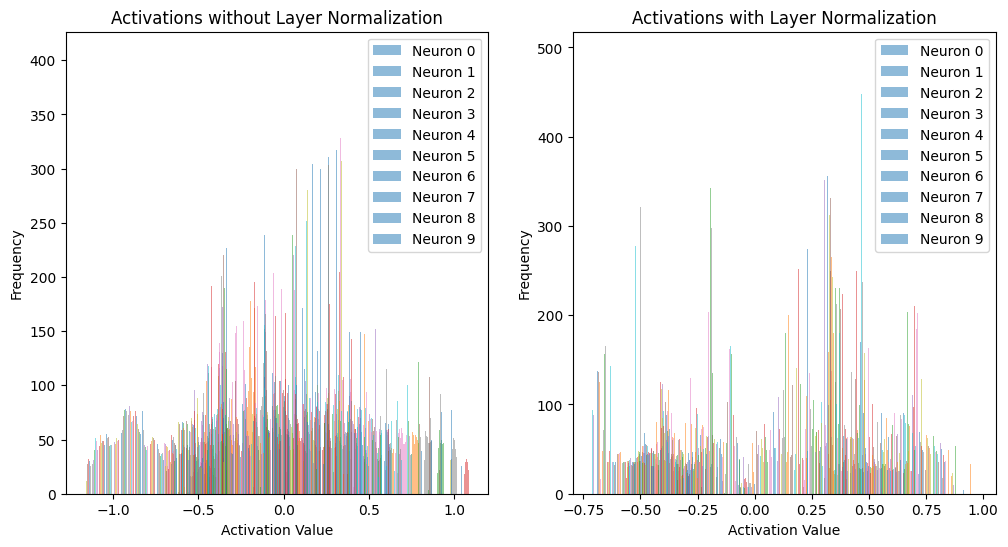

Means without normalization [ 0.23516344  0.5757688  -0.40625852 -0.35992697 -0.73126477  0.01082876
 -0.0874457   0.41399646 -0.10415631 -0.53872085]
Variances without normalization [0.19636111 0.06248114 0.00407601 0.00196877 0.05819619 0.13195343
 0.11140979 0.00879342 0.0007883  0.0080042 ]
Means with normalization [-0.33972636  0.5816071  -0.18178195 -0.40565878  0.2482635   0.41582492
  0.13483447  0.48905182 -0.50530964 -0.10577399]
Variances with normalization [0.0140698  0.00863847 0.00116383 0.00846839 0.00246002 0.00305515
 0.00392337 0.02897381 0.01530552 0.00028469]


In [7]:

# Generate some simple data
x_train_np = np.random.uniform(-1, 1, (1000, 1)).astype(np.float32)
y_train_np = (x_train_np**2 + np.random.normal(0, 0.1, (1000, 1))).astype(np.float32)

x_train = torch.from_numpy(x_train_np)
y_train = torch.from_numpy(y_train_np)

# Train models and collect activations
model_no_norm = create_model(use_layer_norm=False)
activations_no_norm = train_and_collect_activations(model_no_norm, x_train, y_train, model_name="Without Layer Norm")

model_norm = create_model(use_layer_norm=True)
activations_norm = train_and_collect_activations(model_norm, x_train, y_train, model_name="With Layer Norm")

# Visualize the covariance shift
visualize_covariance_shift(activations_no_norm, activations_norm)

#calculate and print mean and variance
means_no_norm, variances_no_norm = calculate_mean_and_variance(activations_no_norm)
means_norm, variances_norm = calculate_mean_and_variance(activations_norm)

print("Means without normalization", means_no_norm[-1])
print("Variances without normalization", variances_no_norm[-1])
print("Means with normalization", means_norm[-1])
print("Variances with normalization", variances_norm[-1])